# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Прикладные задачи анализа данных" </center>

# <center> Лабораторная работа №2. Рекомендательные системы </center>

* В данной лабораторной работе вам предлагается разработать алгоритм рекомендации фильмов.  
* Рекомендацией пользователю будем считать подборку из 10 фильмов.  
* Ожидаемый результат - эти фильмы пользователю понравятся и он высоко их оценит (weak assumption). 

### Задания  
  
1. Выполните разведывательный анализ данных (EDA).  
2. Разработайте алгоритм рекомендации фильмов пользователю. Используйте различные подходы: collaborative filtering (user to user, item to item), content-based, гибридный.  
3. Предложите способ оценки качества алгоритма и оцените качество различных подходов и моделей из предыдущего пункта.  
4. Опишите недостатки и ограничения предложенных вами моделей/алгоритмов и предложите возможные решения для борьбы с ними. 

### Данные 

Данные находятся в архиве `ml-latest-small.zip`.  
Они представляют из себя оценки 9742 фильмов, выставленные 610 пользователями. 
Также для некоторых фильмов известна информация о жанрах в виде тегов.

**Tip:** Вы можете самостоятельно добыть дополнительную информацию о фильмах, используя открытые (или закрытые) источники. Например, данные с IMDb, для взаимодействия с которой есть [специальный модуль](https://github.com/alberanid/imdbpy).  
**NB:** Использование дополнительных данных положительно скажется на оценке.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('white')

In [176]:
ratings = pd.read_csv("data/ratings.csv")
links = pd.read_csv("data/links.csv")
movies = pd.read_csv("data/movies.csv")
tags = pd.read_csv("data/tags.csv")

Я пробовал скачать доп данные с IMDb, но на каждый фильм уходило по 1-3 секунды, из-за чего скачать информацию о всех 10к фильмах стало довольно проблематично.

In [68]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [5]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [6]:
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [7]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [8]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [9]:
tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [11]:
ratings.groupby("movieId").mean().sort_values("rating", ascending=False).merge(movies, on="movieId")[["title", "rating"]].head()

,title,rating
0,Paper Birds (Pájaros de papel) (2010),5.0
1,"Act of Killing, The (2012)",5.0
2,Jump In! (2007),5.0
3,Human (2015),5.0
4,L.A. Slasher (2015),5.0


In [177]:
tmp = movies["genres"].str.get_dummies(sep='|')
tmp.head(2)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [178]:
movies_dummy = pd.concat([movies, tmp], axis=1)
movies_dummy.drop("genres", axis = 1, inplace = True)
movies_dummy.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
movies["ratingCount"] = movies.merge(ratings.groupby('movieId')['rating'].count(), on="movieId", how="left")["rating"]

In [180]:
movies = movies.merge(movies_dummy.drop("title", axis=1), on="movieId", how = "left")

In [181]:
movies[movies["title"].str.contains('\(')==False]

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
6059,40697,Babylon 5,Sci-Fi,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,4.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
9091,143410,Hyena Road,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9179,149334,Nocturnal Animals,Drama|Thriller,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9259,156605,Paterson,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9367,162414,Moonlight,Drama,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9448,167570,The OA,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9514,171495,Cosmos,(no genres listed),2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9515,171631,Maria Bamford: Old Baby,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
movies[movies["(no genres listed)"]==1]

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
8517,114335,La cravate (1957),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8684,122888,Ben-hur (2016),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8782,129250,Superfast! (2015),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8836,132084,Let It Be Me (1995),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8902,134861,Trevor Noah: African American (2013),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9033,141131,Guardians (2016),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9053,141866,Green Room (2015),(no genres listed),3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9070,142456,The Brand New Testament (2015),(no genres listed),2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9091,143410,Hyena Road,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
def parse_title(row):
    yearStart = int(row["title"].rfind("("))
    yearEnd = int(row["title"].rfind(")"))
    if(yearStart!=-1 and yearEnd!=-1):
        year = row["title"][yearStart+1: yearEnd]
        if(year.isdigit()):
            return int(year)
        else:
            return int(-1)
    else:
        return int(-1)
def drop_year(row):
    yearStart = int(row["title"].rfind("("))
    if(yearStart!=-1):
        return row["title"][0:yearStart-1]
    else:
        return row["title"]

In [184]:
movies["year"] = movies.apply(lambda x: parse_title(x), axis=1)

In [185]:
movies["title"] = movies.apply(lambda x: drop_year(x), axis=1)

In [186]:
movies = movies.merge(ratings.groupby("movieId").mean()["rating"], on="movieId")

In [187]:
movies.sort_values("rating", ascending=False)

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,rating
7638,88448,Paper Birds (Pájaros de papel),Comedy|Drama,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2010,5.0
8089,100556,"Act of Killing, The",Documentary,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2012,5.0
9065,143031,Jump In!,Comedy|Drama|Romance,1.0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,2007,5.0
9076,143511,Human,Documentary,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2015,5.0
9078,143559,L.A. Slasher,Comedy|Crime|Fantasy,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2015,5.0
4245,6201,Lady Jane,Drama|Romance,1.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1986,5.0
8136,102217,Bill Hicks: Revelations,Comedy,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1993,5.0
8130,102084,Justice League: Doom,Action|Animation|Fantasy,1.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,2012,5.0
4240,6192,Open Hearts (Elsker dig for evigt),Romance,1.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2002,5.0
9104,145994,Formula of Love,Comedy,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1984,5.0


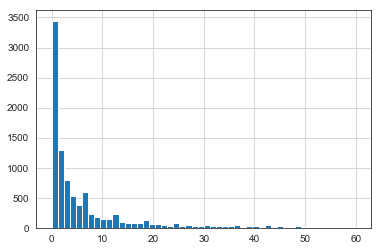

In [188]:
movies["ratingCount"].hist(bins=50, range=(0, 60)) #для большей наглядности смотрим до 60, иначе хвост будет дилнный

In [189]:
movies[movies["year"]==-1]["movieId"]

6042     40697
9013    140956
9073    143410
9120    147250
9161    149334
9241    156605
9349    162414
9430    167570
9496    171495
9497    171631
9500    171749
9507    171891
9593    176601
Name: movieId, dtype: int64

Посмотрим сколько фильмов выпускалось каждый год.

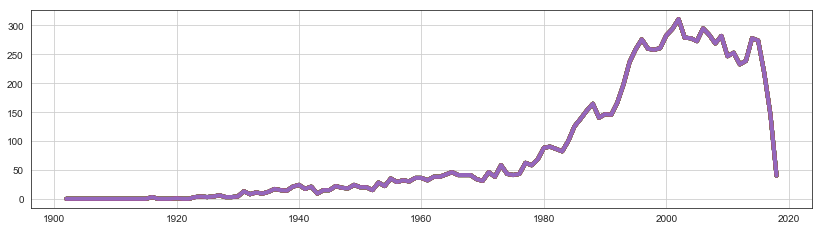

In [190]:
quant=movies[movies['year']!=-1]
fig1, ax1 = plt.subplots(1,1,figsize=(14,8))
plt.subplot(211)
plt.plot(quant.groupby(['year']).count(), linewidth=4.0)
plt.grid(True)

Заметно, что с 1920 по 1970 фильмы выпускались примерно с одинаковой скоростью, но после 1970 произошел заметный скачок. В 2015 сильное падение из-за недостатка данных.

Теперь посмотрим на оценки юзеров!

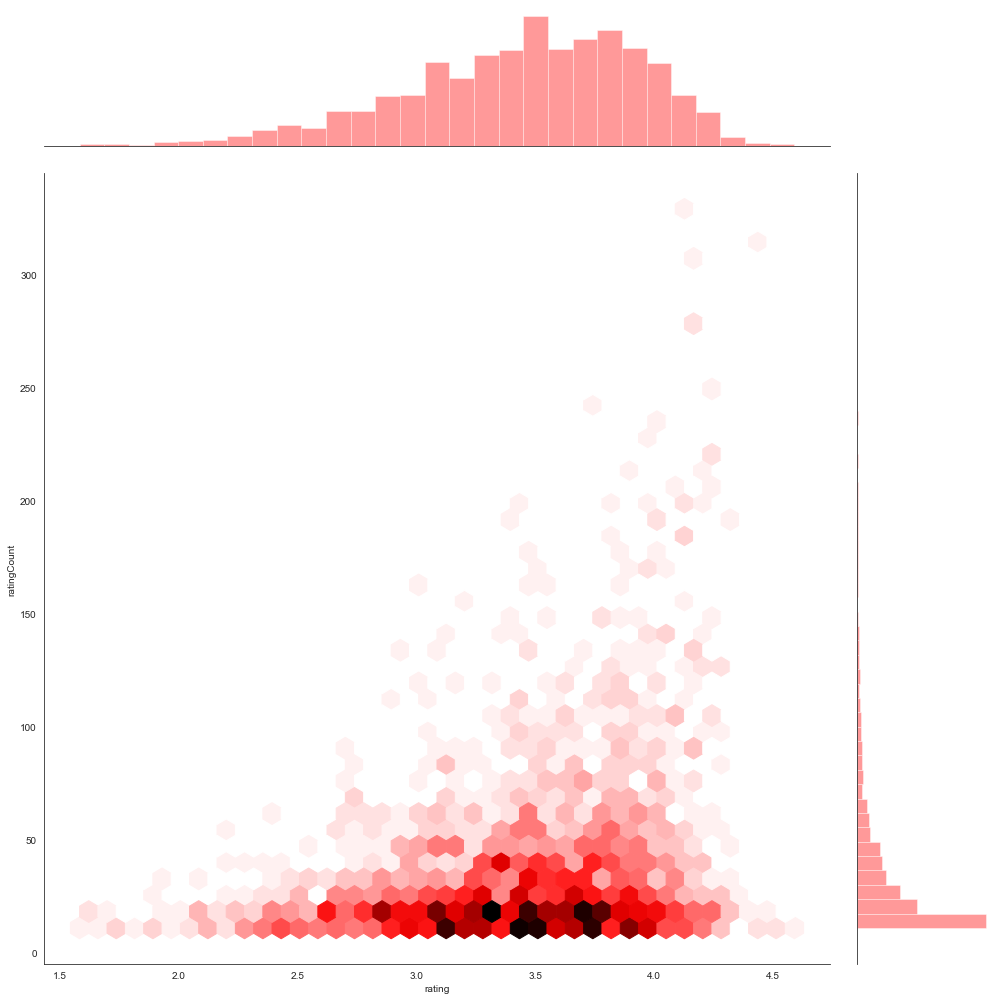

In [191]:
sns.jointplot(x='rating',y='ratingCount', data=movies[movies["ratingCount"]>10], height=14, color='red', kind="hex")

Видно, что самые оцениваемые фильмы имеют оценку выше 4, сто проц этим фильмам единиц понаставили конкуренты и хейтеры.

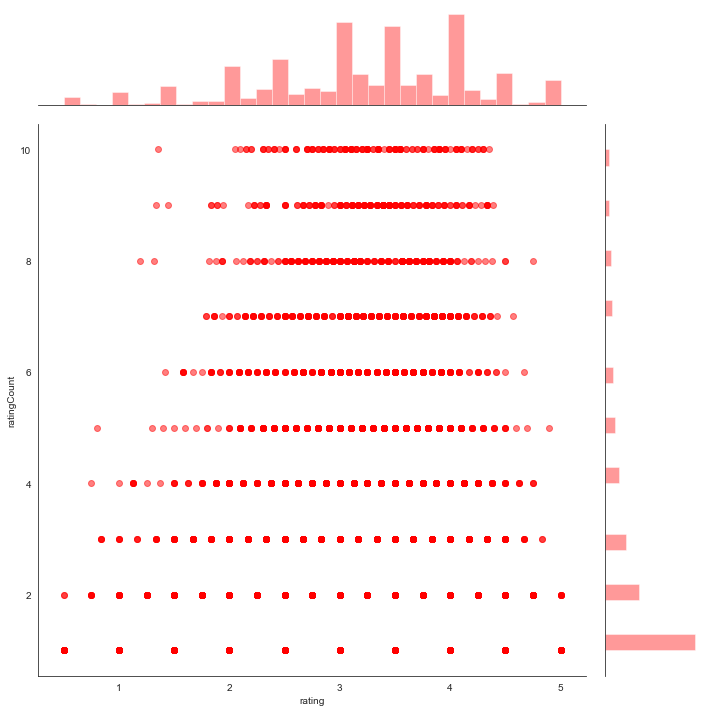

In [192]:
sns.jointplot(x='rating',y='ratingCount', data=movies[movies["ratingCount"]<=10], alpha=0.5, height=10, color='red')

какая-то ерунда на графике выше, пусть будет немного бреда.

In [193]:
genres = set(movies.columns[5:24])

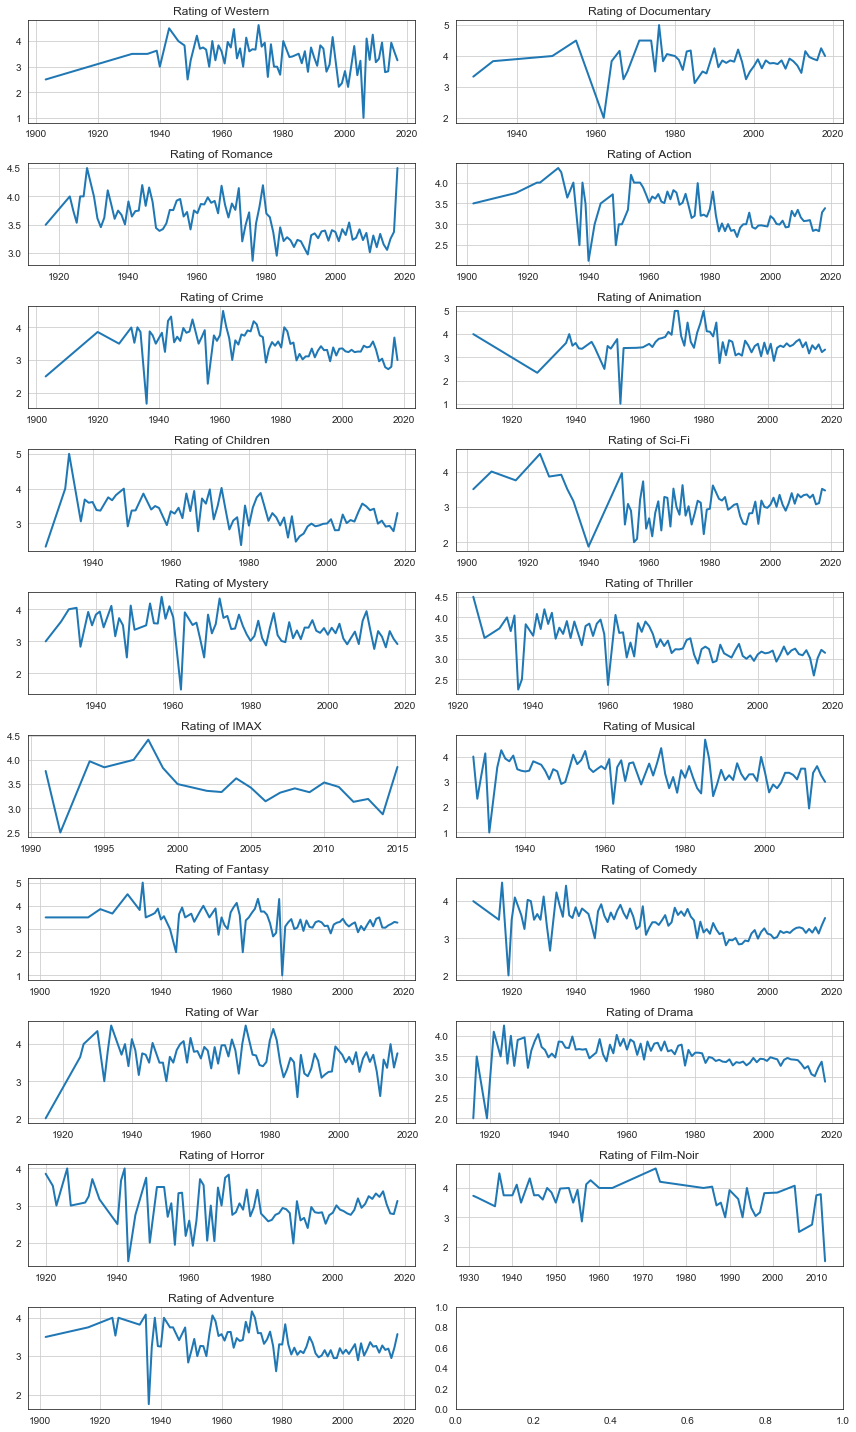

In [194]:
sub = movies[movies["year"]!=-1]
fig, axes = plt.subplots(10,2,figsize=(12,20))
for i, genre in  enumerate(genres, 1):
    genreMovies = sub[sub[genre]==1].groupby("year").mean()["rating"]
    axes[(i-1)//2, (i-1)%2].plot(genreMovies, linewidth=2.0)
    axes[(i-1)//2, (i-1)%2].title.set_text("Rating of %s"%genre)
    axes[(i-1)//2, (i-1)%2].grid(True)
fig.tight_layout()


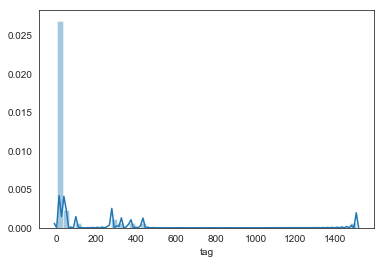

In [195]:
sns.distplot(tags.groupby("userId").count()["tag"])

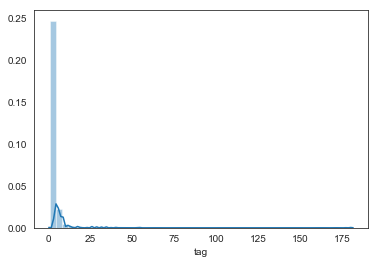

In [196]:
sns.distplot(tags.groupby("movieId").count()["tag"])

In [197]:
sub = tags.groupby("movieId").count()

In [198]:
movies = movies.merge(sub["tag"], on="movieId")

In [199]:
movies

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,rating,tag
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,215.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,1995,3.920930,3
1,2,Jumanji,Adventure|Children|Fantasy,110.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1995,3.431818,4
2,3,Grumpier Old Men,Comedy|Romance,52.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1995,3.259615,2
3,5,Father of the Bride Part II,Comedy,49.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1995,3.071429,2
4,7,Sabrina,Comedy|Romance,54.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1995,3.185185,1
5,11,"American President, The",Comedy|Drama|Romance,70.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1995,3.671429,2
6,14,Nixon,Drama,18.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1995,3.833333,2
7,16,Casino,Crime|Drama,82.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1995,3.926829,1
8,17,Sense and Sensibility,Drama|Romance,67.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1995,3.776119,1
9,21,Get Shorty,Comedy|Crime|Thriller,89.0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1995,3.494382,1


In [200]:
tagCountBygenre = dict()
for genre in genres:
    tagCountBygenre[genre] = movies[movies[genre]==1]["tag"].sum()

In [201]:
tagCountBygenre

{'Western': 62,
 'Documentary': 110,
 'Romance': 610,
 'Action': 837,
 'Crime': 797,
 'Animation': 233,
 'Children': 185,
 'Sci-Fi': 688,
 'Mystery': 396,
 'Thriller': 1094,
 'IMAX': 163,
 'Musical': 121,
 'Fantasy': 301,
 'Comedy': 1151,
 'War': 162,
 'Drama': 2082,
 'Horror': 223,
 'Film-Noir': 45,
 'Adventure': 632}

In [209]:
pd.DataFrame(tagCountBygenre, index=[0]).T

,0
Western,62
Documentary,110
Romance,610
Action,837
Crime,797
Animation,233
Children,185
Sci-Fi,688
Mystery,396
Thriller,1094


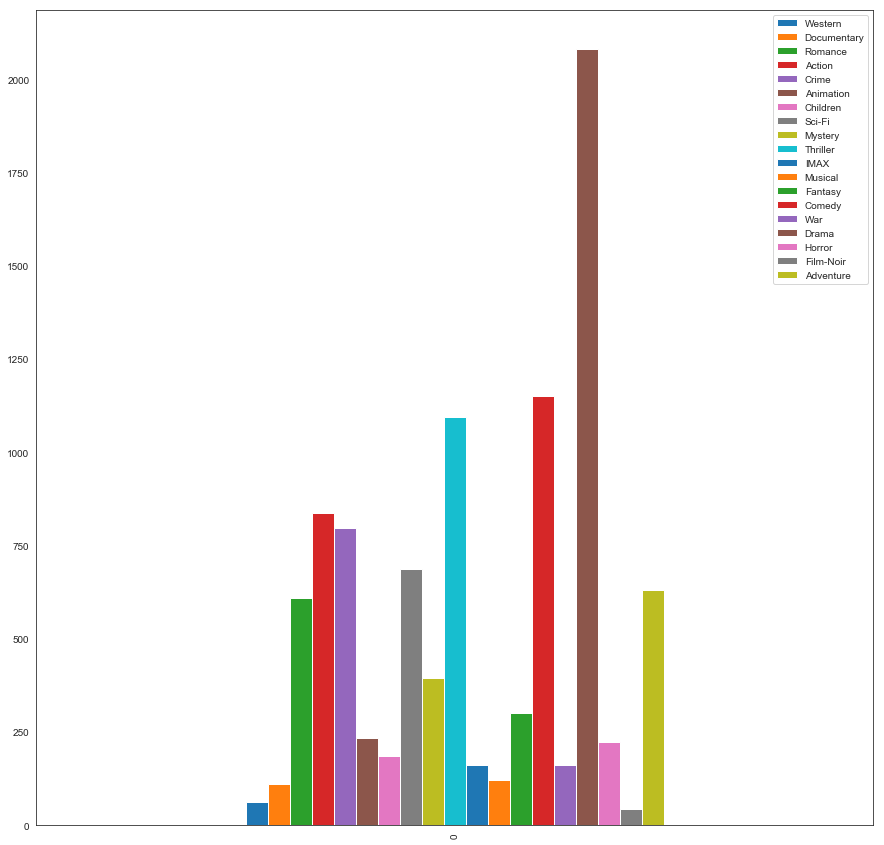

In [219]:
pd.DataFrame(tagCountBygenre, index=[0]).plot(kind="bar", figsize=(15,15))

In [223]:
tags.groupby("tag").count().sort_values("movieId", ascending=False).head()

,userId,movieId,timestamp
tag,,,
In Netflix queue,131,131,131
atmospheric,36,36,36
thought-provoking,24,24,24
superhero,24,24,24
Disney,23,23,23
